# Introducción al Proyecto de Optimización de Gastos de Marketing

**Descripción del Proyecto**

En el marco de las prácticas ofrecidas en el departamento analítico de Y.Afisha, la tarea consiste en optimizar los gastos de marketing de la empresa. Para llevar a cabo este análisis, disponemos de una serie de datos que nos permitirán evaluar cómo los clientes interactúan con el servicio, cuándo comienzan a realizar compras, cuánto contribuyen financieramente a la compañía y cuándo los ingresos generados cubren el costo de adquisición de los clientes.

**Datos Disponibles**

Contamos con tres conjuntos de datos principales que proporcionan información clave para el análisis:

**Registros del Servidor (visitas):**

- **Archivo:** `/datasets/visits_log_us.csv`
- **Descripción:** Contiene datos sobre las visitas al sitio web de Y.Afisha desde enero de 2017 hasta diciembre de 2018. Las columnas incluyen:
  - `Uid`: Identificador único del usuario.
  - `Device`: Dispositivo utilizado por el usuario.
  - `Start Ts`: Fecha y hora de inicio de la sesión.
  - `End Ts`: Fecha y hora de término de la sesión.
  - `Source Id`: Identificador de la fuente de anuncios de la que proviene el usuario.
- **Formato de Fechas:** Todas las fechas están en formato AAAA-MM-DD.

**Datos de Pedidos:**

- **Archivo:** `/datasets/orders_log_us.csv`
- **Descripción:** Incluye información sobre los pedidos realizados durante el período mencionado. Las columnas son:
  - `Uid`: Identificador único del usuario que realiza el pedido.
  - `Buy Ts`: Fecha y hora del pedido.
  - `Revenue`: Ingresos generados para Y.Afisha por este pedido.

**Gastos de Marketing:**

- **Archivo:** `/datasets/costs_us.csv`
- **Descripción:** Detalla los gastos asociados a las distintas fuentes de anuncios. Las columnas incluyen:
  - `source_id`: Identificador de la fuente de anuncios.
  - `dt`: Fecha de los gastos.
  - `costs`: Monto gastado en la fuente de anuncios en esa fecha.

**Objetivos del Análisis**

En este proyecto, el enfoque estará en las siguientes áreas clave:

**Uso del Servicio por los Clientes:**

- Determinar el número de usuarios diarios, semanales y mensuales.
- Calcular el número de sesiones por día y la duración promedio de cada sesión.
- Evaluar la frecuencia con la que los usuarios regresan al sitio web.

**Análisis de Ventas:**

- Investigar el tiempo que transcurre entre el registro de un usuario y su primera compra.
- Determinar la frecuencia de pedidos y el tamaño promedio de compra.
- Calcular el valor total aportado por cada cliente (LTV).

**Evaluación del Marketing:**

- Analizar el gasto total y desglosado por fuente de adquisición y tiempo.
- Calcular el costo de adquisición de clientes para cada fuente.
- Evaluar la rentabilidad de las inversiones en marketing (ROMI).


## Importar librerias

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.stats import norm

##   Descargar los datos y prepáralos para el análisis

In [2]:
visits = pd.read_csv('/datasets/visits_log_us.csv')
orders = pd.read_csv('/datasets/orders_log_us.csv')
costs = pd.read_csv('/datasets/costs_us.csv')

In [3]:
visits.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Device     359400 non-null  object
 1   End Ts     359400 non-null  object
 2   Source Id  359400 non-null  int64 
 3   Start Ts   359400 non-null  object
 4   Uid        359400 non-null  uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 79.3 MB


In [4]:
orders.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Buy Ts   50415 non-null  object 
 1   Revenue  50415 non-null  float64
 2   Uid      50415 non-null  uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 4.4 MB


In [5]:
costs.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source_id  2542 non-null   int64  
 1   dt         2542 non-null   object 
 2   costs      2542 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 206.2 KB


In [6]:
visits = pd.read_csv(
    '/datasets/visits_log_us.csv',
    dtype={
        'Device': 'category',    # Convertimos 'Device' a 'category' para reducir el uso de memoria
        'Source Id': 'int32',    # Usamos un tipo entero más pequeño si los valores lo permiten
        'Uid': 'uint64'          # Mantenemos 'Uid' como 'uint64' porque parece contener valores grandes
    },
    parse_dates=['Start Ts', 'End Ts'],  # Convertimos las columnas de fechas a datetime para optimizar el manejo de fechas
)

In [7]:
orders = pd.read_csv(
    '/datasets/orders_log_us.csv',
    dtype={
        'Uid': 'uint64',         # Mantenemos 'Uid' como 'uint64' porque parece contener valores grandes
        'Revenue': 'float32'     # Convertimos 'Revenue' a 'float32' para reducir el uso de memoria si la precisión lo permite
    },
    parse_dates=['Buy Ts'],       # Convertimos 'Buy Ts' a datetime para optimizar el manejo de fechas
)

In [8]:
costs = pd.read_csv(
    '/datasets/costs_us.csv',
    dtype={
        'source_id': 'uint16',   # Cambiamos 'source_id' a 'uint16' ya que parece manejar valores pequeños
        'costs': 'float32'       # Convertimos 'costs' a 'float32' para reducir el uso de memoria
    },
    parse_dates=['dt'],          # Convertimos 'dt' a datetime para optimizar el manejo de fechas
)

In [9]:
visits.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   Device     359400 non-null  category      
 1   End Ts     359400 non-null  datetime64[ns]
 2   Source Id  359400 non-null  int32         
 3   Start Ts   359400 non-null  datetime64[ns]
 4   Uid        359400 non-null  uint64        
dtypes: category(1), datetime64[ns](2), int32(1), uint64(1)
memory usage: 9.9 MB


In [10]:
orders.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Buy Ts   50415 non-null  datetime64[ns]
 1   Revenue  50415 non-null  float32       
 2   Uid      50415 non-null  uint64        
dtypes: datetime64[ns](1), float32(1), uint64(1)
memory usage: 984.8 KB


In [11]:
costs.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   source_id  2542 non-null   uint16        
 1   dt         2542 non-null   datetime64[ns]
 2   costs      2542 non-null   float32       
dtypes: datetime64[ns](1), float32(1), uint16(1)
memory usage: 34.9 KB


## Informes

### Visitas

#### Visitas por día, semana y mes

**Agregamos columnas adicionales por año, mes, semana y día**

In [12]:
visits['visit_month'] = visits['Start Ts'].astype('datetime64[M]')
visits['visit_day'] = visits['Start Ts'].dt.day
visits['visit_week'] = visits['Start Ts'].dt.isocalendar().week
visits['visit_year'] = visits['Start Ts'].dt.year

**Agrupamos por semana y día**

In [13]:
# Contar usuarios por día
daily_users = visits.groupby(['visit_year', 'visit_month', 'visit_day'])['Uid'].nunique()

# Contar usuarios por semana
weekly_users = visits.groupby(['visit_year', 'visit_week'])['Uid'].nunique()

In [14]:
daily_users.describe()

count     364.000000
mean      907.991758
std       370.513838
min         1.000000
25%       594.000000
50%       921.000000
75%      1173.000000
max      3319.000000
Name: Uid, dtype: float64

##### Visitas por día, semana y mes

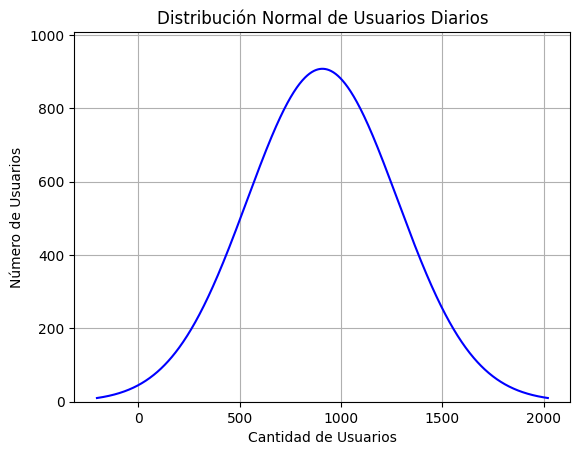

In [15]:
# Parámetros de la distribución normal
mu = 907.99  # Media
sigma = 370.51  # Desviación estándar

# Generar valores en el eje x (usuarios) alrededor de la media
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 1000)

# Calcular la distribución normal (campana de Gauss)
y = norm.pdf(x, mu, sigma)

# Escalar la PDF para que la altura máxima sea igual a la media
y = y * (mu / max(y))

# Crear la gráfica
plt.plot(x, y, color='blue')
plt.title('Distribución Normal de Usuarios Diarios')
plt.xlabel('Cantidad de Usuarios')
plt.ylabel('Número de Usuarios')
plt.grid(True)

# Ajustar el rango del eje y para que la altura máxima sea más visible
plt.ylim(0, max(y) + 100)

plt.show()

Este análisis estadístico resume la distribución diaria de usuarios únicos en la plataforma de Y.Afisha a lo largo de un año (364 días). El valor promedio (mean) de usuarios diarios es de aproximadamente 908, con una desviación estándar (std) de 371, lo que indica una variabilidad moderada en el número de usuarios diarios. El valor mínimo (min) de usuarios en un día fue 1, mientras que el máximo (max) alcanzó los 3,319 usuarios. El 25% de los días tuvo 594 o menos usuarios (25% percentile), la mediana (50%) es de 921 usuarios diarios, y el 75% de los días tuvo 1,173 o más usuarios (75% percentile). Esta información es crucial para entender el comportamiento y la afluencia diaria de usuarios en la plataforma.

##### Distribución Normal de Usuarios Semanales

In [16]:
weekly_users.describe()

count       53.000000
mean      5716.245283
std       2049.898027
min       2021.000000
25%       4128.000000
50%       5740.000000
75%       7401.000000
max      10586.000000
Name: Uid, dtype: float64

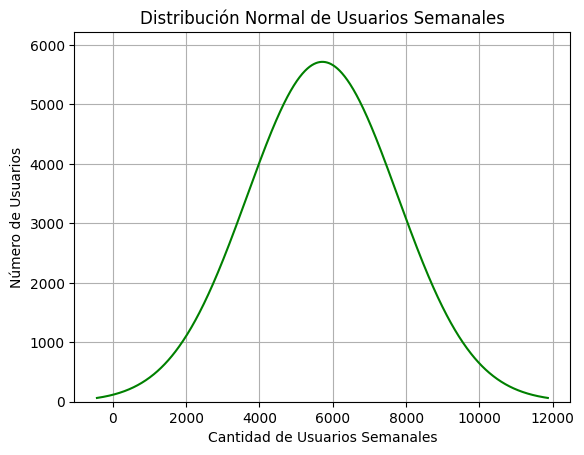

In [17]:
# Parámetros de la distribución normal
mu = 5716.25  # Media
sigma = 2049.90  # Desviación estándar

# Generar valores en el eje x (usuarios) alrededor de la media
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 1000)

# Calcular la distribución normal (campana de Gauss)
y = norm.pdf(x, mu, sigma)

# Escalar la PDF para que la altura máxima sea igual a la media
y = y * (mu / max(y))

# Crear la gráfica
plt.plot(x, y, color='green')
plt.title('Distribución Normal de Usuarios Semanales')
plt.xlabel('Cantidad de Usuarios Semanales')
plt.ylabel('Número de Usuarios')
plt.grid(True)

# Ajustar el rango del eje y para que la altura máxima sea más visible
plt.ylim(0, max(y) + 500)

plt.show()

Este análisis estadístico describe la distribución semanal de usuarios únicos en la plataforma de Y.Afisha a lo largo de 53 semanas. El número promedio (mean) de usuarios por semana es de aproximadamente 5,716, con una desviación estándar (std) de alrededor de 2,050, lo que sugiere una variabilidad considerable en la cantidad de usuarios semanales. La semana con menor afluencia (min) tuvo 2,021 usuarios, mientras que la semana con mayor afluencia (max) registró 10,586 usuarios. El 25% de las semanas tuvo 4,128 o menos usuarios (percentile 25%), la mediana (50%) es de 5,740 usuarios semanales, y el 75% de las semanas contó con 7,401 o más usuarios (percentile 75%). Estos datos son fundamentales para evaluar las tendencias semanales de uso y planificar estrategias basadas en el comportamiento de los usuarios.

##### Visitas Mensuales de Usuarios

**Preparamos los datos para un analisis de cohortes**

In [18]:
first_visit_date = visits.groupby('Uid')['Start Ts'].min()
first_visit_date.name = 'first_visit_date'
visits = visits.join(first_visit_date, on='Uid')
visits['first_visit_month'] = visits['first_visit_date'].astype('datetime64[M]')
visits

,Device,End Ts,Source Id,Start Ts,Uid,visit_month,visit_day,visit_week,visit_year,first_visit_date,first_visit_month
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-01,20,51,2017,2017-12-20 17:20:00,2017-12-01
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-01,19,8,2018,2018-02-19 16:53:00,2018-02-01
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,1,26,2017,2017-07-01 01:54:00,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-01,20,20,2018,2018-03-09 20:05:00,2018-03-01
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-01,27,52,2017,2017-12-27 14:06:00,2017-12-01
...,...,...,...,...,...,...,...,...,...,...,...
359395,desktop,2017-07-29 19:07:19,2,2017-07-29 19:07:00,18363291481961487539,2017-07-01,29,30,2017,2017-07-29 19:07:00,2017-07-01
359396,touch,2018-01-25 17:38:19,1,2018-01-25 17:38:00,18370831553019119586,2018-01-01,25,4,2018,2018-01-25 17:38:00,2018-01-01
359397,desktop,2018-03-03 10:12:19,4,2018-03-03 10:12:00,18387297585500748294,2018-03-01,3,9,2018,2018-03-03 10:12:00,2018-03-01
359398,desktop,2017-11-02 10:12:19,5,2017-11-02 10:12:00,18388616944624776485,2017-11-01,2,44,2017,2017-11-02 10:12:00,2017-11-01


**Crear una tabla dinámica de visitas por mes y primera visita**

In [19]:
heatmap_data = visits.pivot_table(
    index=visits['first_visit_month'].dt.strftime('%Y-%m-%d'),  # Usar la primera visita como índice
    columns=visits['visit_month'].dt.strftime('%Y-%m'),       # Usar el mes de visita como columnas
    values='Uid',                                              # Contar usuarios únicos (Uid)
    aggfunc='count'                                            # Función de agregación: número de visitas
)
heatmap_data

visit_month,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05
first_visit_month,,,,,,,,,,,,
2017-06-01,16505.0,2412.0,1758.0,2260.0,2679.0,2972.0,2714.0,2232.0,2109.0,1981.0,1623.0,1618.0
2017-07-01,NaN,15416.0,1156.0,1168.0,1280.0,1395.0,1079.0,938.0,959.0,813.0,596.0,570.0
2017-08-01,NaN,NaN,11441.0,1201.0,1025.0,1046.0,899.0,755.0,613.0,727.0,505.0,459.0
2017-09-01,NaN,NaN,NaN,19278.0,2190.0,1931.0,1402.0,977.0,951.0,901.0,583.0,582.0
2017-10-01,NaN,NaN,NaN,NaN,30729.0,3309.0,2116.0,1481.0,1280.0,1197.0,781.0,789.0
2017-11-01,NaN,NaN,NaN,NaN,NaN,33316.0,3801.0,2221.0,1873.0,1422.0,863.0,887.0
2017-12-01,NaN,NaN,NaN,NaN,NaN,NaN,29972.0,2274.0,1490.0,1167.0,675.0,680.0
2018-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26061.0,2275.0,1446.0,757.0,650.0
2018-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25632.0,1988.0,784.0,695.0


**Mapa de Calor de Cohortes de Visitas Mensuales de Usuarios**

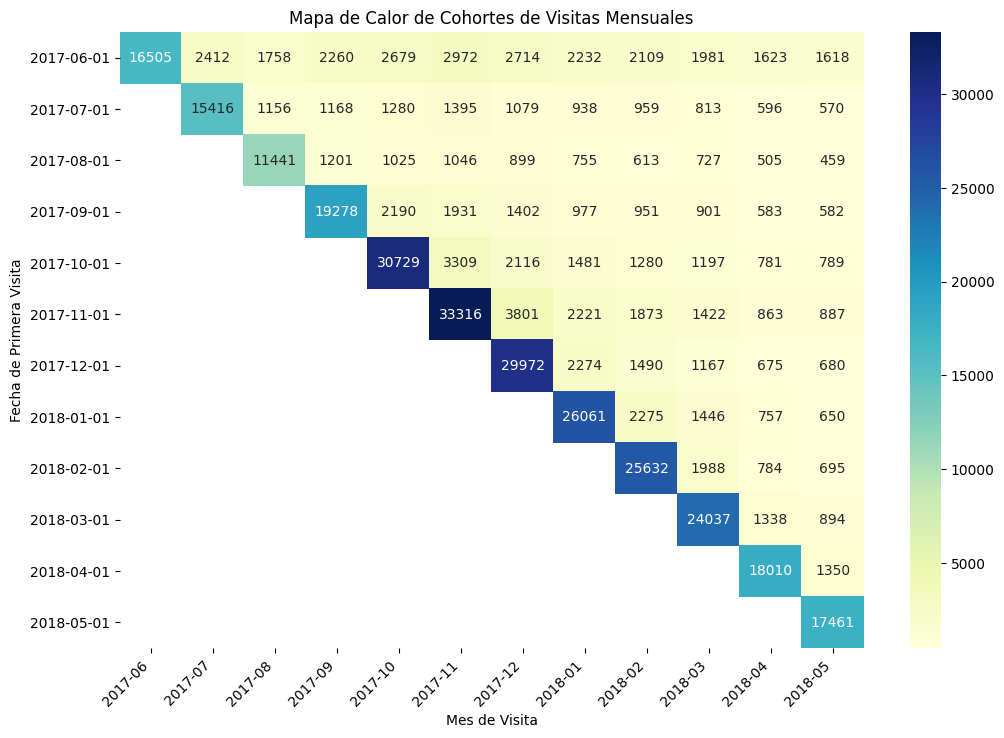

In [20]:
# Crear la figura y los ejes
plt.figure(figsize=(12, 8))

# Crear el heatmap
sns.heatmap(heatmap_data, cmap="YlGnBu", annot=True, fmt=".0f")

# Ajustar las etiquetas del eje x
plt.xticks(rotation=45, ha='right')  # Rotar las etiquetas para una mejor visualización

# Agregar título y etiquetas
plt.title("Mapa de Calor de Cohortes de Visitas Mensuales")
plt.xlabel("Mes de Visita")
plt.ylabel("Fecha de Primera Visita")

# Mostrar la gráfica
plt.show()

**Análisis de la Tabla de Visitas Mensuales**

Algunos datos relevantes que se pueden extraer de la tabla de visitas mensuales son:

1. **Visitas iniciales altas:**
   - Los usuarios tienden a realizar muchas visitas en el mes de su primera visita.
   - Ejemplos:
     - Junio de 2017: 16,505 visitas.
     - Octubre de 2017: 30,729 visitas.

2. **Descenso gradual en las visitas:**
   - Hay una tendencia general a que las visitas disminuyan en los meses siguientes a la primera visita.
   - Ejemplo:
     - Usuarios que comenzaron en octubre de 2017:
       - Noviembre de 2017: 3,309 visitas, en comparación con las 30,729 visitas iniciales.

3. **Patrones de retención:**
   - Algunos meses muestran una mejor retención que otros.
   - Ejemplo:
     - Usuarios que comenzaron en septiembre de 2017:
       - Octubre de 2017: 21,278 visitas, con una caída en noviembre.

4. **Picos en la actividad:**
   - Se pueden identificar picos de actividad en ciertos meses.
   - Ejemplo:
     - Mayo de 2018: Las visitas se mantienen relativamente altas en comparación con otros meses del mismo año.

5. **Meses de alta actividad:**
   - Octubre de 2017 y noviembre de 2017 parecen ser meses de alta actividad, con picos significativos en las visitas iniciales y continuas en los meses siguientes.

6. **Diferencias entre cohortes:**
   - La diferencia en el comportamiento entre las cohortes de usuarios que comenzaron en diferentes meses puede sugerir factores estacionales o cambios en la plataforma que afectaron la retención y la actividad de los usuarios.

#### Sesiones por día

##### Sesiones totales diarias

In [21]:
# Contar el número de sesiones por día
daily_sessions = visits.groupby(['visit_year', 'visit_month', 'visit_day']).size()
daily_sessions.describe()

count     364.000000
mean      987.362637
std       418.994796
min         1.000000
25%       635.500000
50%      1003.000000
75%      1280.000000
max      4042.000000
dtype: float64

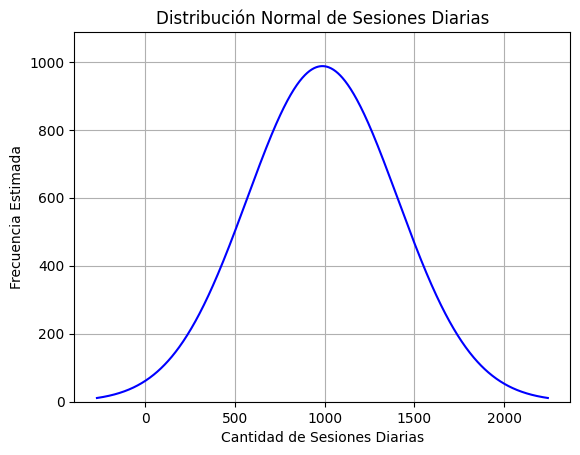

In [22]:
# Calcular la media y desviación estándar de las sesiones diarias
mu = daily_sessions.mean()
sigma = daily_sessions.std()

# Generar valores en el eje x alrededor de la media
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 1000)

# Calcular la distribución normal (campana de Gauss)
y = norm.pdf(x, mu, sigma)

# Escalar la PDF para que la altura máxima sea igual a la media
y = y * (mu / max(y))

# Crear la gráfica
plt.plot(x, y, color='blue')
plt.title('Distribución Normal de Sesiones Diarias')
plt.xlabel('Cantidad de Sesiones Diarias')
plt.ylabel('Frecuencia Estimada')
plt.grid(True)

# Ajustar el rango del eje y para que la altura máxima sea más visible
plt.ylim(0, max(y) + 100)

# Mostrar la gráfica
plt.show()

**Promedio de sesiones diarias (`mean = 987.36`)**:  
En promedio, la plataforma recibe alrededor de 987 sesiones por día. Esto indica un nivel de actividad diaria que se mantiene bastante constante en ese rango.

**Variabilidad en las sesiones diarias (`std = 418.99`)**:  
La desviación estándar es de aproximadamente 419 sesiones, lo que indica que hay una variabilidad considerable en el número de sesiones diarias. Algunos días tienen muchas más sesiones que otros.

**Sesiones mínimas (`min = 1`)**:  
El mínimo de sesiones registradas en un día es 1, lo que podría indicar días con problemas de registro de datos o días con muy poca actividad.

**Sesiones máximas (`max = 4042`)**:  
El máximo de sesiones en un solo día es 4042, lo que podría ser un pico de actividad debido a algún evento especial, promoción, o un aumento repentino en el tráfico.

**Distribución de las sesiones**:
- **Percentil 25 (`25% = 635.5`)**: El 25% de los días tiene menos de 636 sesiones, lo que sugiere que una cuarta parte del tiempo, la actividad es relativamente baja.
- **Mediana (`50% = 1003`)**: La mediana es de 1003 sesiones por día, lo que significa que la mitad de los días tiene más de 1003 sesiones y la otra mitad menos.
- **Percentil 75 (`75% = 1280`)**: El 75% de los días tiene menos de 1280 sesiones, indicando que solo un cuarto de los días tienen un nivel de actividad significativamente más alto que la mediana.

**Conclusiones**:
- **Variabilidad en la actividad**: La plataforma experimenta una variabilidad considerable en el número de sesiones diarias, con días de alta y baja actividad.
- **Sesiones promedio estables**: Aunque hay picos en algunos días, el promedio se mantiene alrededor de 987 sesiones por día, lo que podría indicar un flujo regular de usuarios, con eventos esporádicos que causan aumentos significativos.
- **Distribución asimétrica**: La diferencia entre la mediana y la media, junto con el alto valor máximo, sugiere que la distribución podría estar sesgada hacia la derecha, con algunos días excepcionales de alta actividad que aumentan la media.


##### Sesiones Múltiples por Día

In [23]:
# Contar sesiones por usuario y por día
user_daily_sessions = visits.groupby(['Uid', 'visit_year', 'visit_month', 'visit_day']).size()

# Filtrar para obtener solo los usuarios que entraron más de una vez por día
multiple_sessions_per_day = user_daily_sessions[user_daily_sessions > 1]

# Contar el número de sesiones por día para usuarios con múltiples sesiones
multiple_sessions_count = multiple_sessions_per_day.groupby(['visit_year', 'visit_month', 'visit_day']).size()

multiple_sessions_count.describe()

count    363.000000
mean      62.181818
std       39.345403
min        3.000000
25%       36.500000
50%       60.000000
75%       80.000000
max      521.000000
dtype: float64

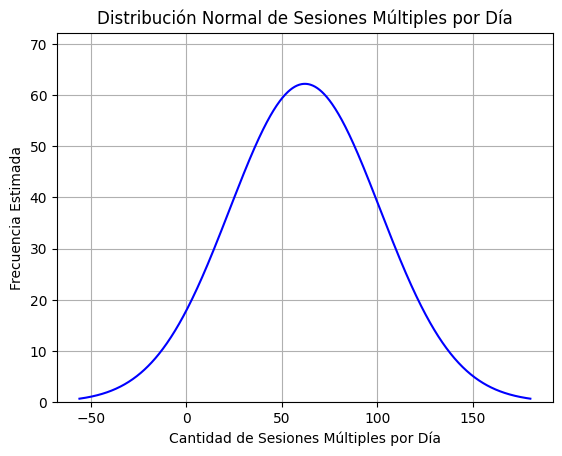

In [24]:
# Calcular la media y desviación estándar de las sesiones múltiples por día
mu_multiple = multiple_sessions_count.mean()
sigma_multiple = multiple_sessions_count.std()

# Generar valores en el eje x alrededor de la media
x_multiple = np.linspace(mu_multiple - 3*sigma_multiple, mu_multiple + 3*sigma_multiple, 1000)

# Calcular la distribución normal (campana de Gauss)
y_multiple = norm.pdf(x_multiple, mu_multiple, sigma_multiple)

# Escalar la PDF para que la altura máxima sea igual a la media
y_multiple = y_multiple * (mu_multiple / max(y_multiple))

# Crear la gráfica
plt.plot(x_multiple, y_multiple, color='blue')
plt.title('Distribución Normal de Sesiones Múltiples por Día')
plt.xlabel('Cantidad de Sesiones Múltiples por Día')
plt.ylabel('Frecuencia Estimada')
plt.grid(True)

# Ajustar el rango del eje y para que la altura máxima sea más visible
plt.ylim(0, max(y_multiple) + 10)

# Mostrar la gráfica
plt.show()

**Promedio de sesiones múltiples por día (mean = 62.18):**  
En promedio, alrededor de 62 sesiones múltiples (es decir, sesiones adicionales por usuarios que ya habían iniciado una sesión ese día) se registraron diariamente.

**Variabilidad en las sesiones múltiples (std = 39.35):**  
La desviación estándar de aproximadamente 39.35 indica una variabilidad significativa en el número de sesiones múltiples por día. Algunos días tienen muchas más sesiones múltiples que otros.

**Sesiones múltiples mínimas (min = 3):**  
El número mínimo de sesiones múltiples en un día es 3. Esto sugiere que, en el día menos activo en cuanto a sesiones múltiples, solo tres usuarios realizaron más de una sesión.

**Sesiones múltiples máximas (max = 521):**  
El máximo de sesiones múltiples en un día es 521. Este podría ser un día especial con un aumento inusual en la actividad, posiblemente debido a una campaña, un evento, o un día con picos de interés en la plataforma.

**Distribución de las sesiones múltiples:**

- **Percentil 25 (25% = 36.5):** El 25% de los días tienen menos de 37 sesiones múltiples, lo que indica que en una cuarta parte del tiempo, la actividad en términos de sesiones múltiples es relativamente baja.
- **Mediana (50% = 60):** La mediana es de 60 sesiones múltiples por día, lo que significa que la mitad de los días tienen más de 60 sesiones múltiples y la otra mitad menos.
- **Percentil 75 (75% = 80):** El 75% de los días tienen menos de 80 sesiones múltiples, sugiriendo que solo en un cuarto de los días, la actividad es significativamente más alta que la mediana.

**Conclusiones:**

- **Actividad consistente:** Aunque hay variabilidad, un número significativo de días registra múltiples sesiones por usuario, lo que indica un nivel consistente de compromiso entre los usuarios.
- **Picos de actividad:** Los valores máximos sugieren que ciertos días tienen picos de actividad, lo cual podría estar relacionado con factores específicos, como promociones o eventos que motivan a los usuarios a interactuar más con la plataforma.
- **Distribución de la actividad:** La diferencia entre la mediana y la media, junto con el alto valor máximo, sugiere que la distribución podría estar sesgada hacia la derecha, con algunos días de actividad excepcionalmente alta que influyen en el promedio general.


#### Duración de cada sesión

**Calcular la duración de las visitas**

In [25]:
visits['session_duration'] = ((visits['End Ts'] - visits['Start Ts']).dt.total_seconds() / 60).astype(int)
visits.describe()

,Source Id,Uid,visit_day,visit_week,visit_year,session_duration
count,359400.000000,3.594000e+05,359400.000000,359400.000000,359400.000000,359400.000000
mean,3.750515,9.202557e+18,16.006377,26.970907,2017.453395,10.716330
std,1.917116,5.298433e+18,8.766358,16.773920,0.497824,16.619282
min,1.000000,1.186350e+13,1.000000,1.000000,2017.000000,-46.000000
25%,3.000000,4.613407e+18,8.000000,11.000000,2017.000000,2.000000
50%,4.000000,9.227413e+18,16.000000,26.000000,2017.000000,5.000000
75%,5.000000,1.372824e+19,24.000000,43.000000,2018.000000,14.000000
max,10.000000,1.844668e+19,31.000000,52.000000,2018.000000,711.000000


**Revisar la información sobre la duración de las sesiones que tienen tiempos negativos**

In [26]:
negative_duration = visits[visits['session_duration'] < 0]

# Mostrar las filas con duración negativa
negative_duration

,Device,End Ts,Source Id,Start Ts,Uid,visit_month,visit_day,visit_week,visit_year,first_visit_date,first_visit_month,session_duration
4181,desktop,2018-03-25 03:18:00,3,2018-03-25 03:50:00,13092152539246794986,2018-03-01,25,12,2018,2017-11-12 16:49:00,2017-11-01,-32
177972,desktop,2018-03-25 03:09:00,9,2018-03-25 03:55:00,4621202742905035453,2018-03-01,25,12,2018,2018-03-19 18:40:00,2018-03-01,-46


La duración de la sesión es negativa en estas filas porque la marca de tiempo de End Ts (hora de finalización) es anterior a la de Start Ts (hora de inicio). Esto puede suceder debido a varios factores:

**Error de registro:** Los datos podrían haberse registrado incorrectamente, intercambiando las marcas de tiempo de inicio y finalización.

**Diferencias en la zona horaria:** Si las marcas de tiempo se capturaron en diferentes zonas horarias y no se ajustaron correctamente, podría dar como resultado una hora de finalización anterior a la de inicio.

**Problemas de sincronización del sistema:** Si los relojes de los dispositivos que registraron los eventos no estaban sincronizados correctamente, podría haber inconsistencias en las marcas de tiempo.


**Creación de Tabla Dinámica sobre la Duración Promedio de Cada Sesión**

In [27]:
# Crear la Tabla Dinámica con los Datos Filtrados
heatmap_duration = visits.pivot_table(
    index=visits['first_visit_month'].dt.strftime('%Y-%m-%d'),  # Usar la primera visita como índice
    columns=visits['visit_month'].dt.strftime('%Y-%m'),       # Usar el mes de visita como columnas
    values='session_duration',                                 # Contar usuarios únicos (Uid)
    aggfunc='mean'                                            # Función de agregación: número de visitas
)

# Redondear los valores a enteros más cercanos
heatmap_duration.round()

visit_month,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05
first_visit_month,,,,,,,,,,,,
2017-06-01,10.0,16.0,16.0,17.0,16.0,18.0,18.0,17.0,17.0,16.0,16.0,17.0
2017-07-01,NaN,9.0,14.0,12.0,12.0,14.0,12.0,11.0,12.0,12.0,11.0,10.0
2017-08-01,NaN,NaN,8.0,11.0,11.0,12.0,12.0,12.0,13.0,14.0,18.0,16.0
2017-09-01,NaN,NaN,NaN,9.0,12.0,13.0,13.0,11.0,12.0,12.0,9.0,9.0
2017-10-01,NaN,NaN,NaN,NaN,9.0,14.0,14.0,13.0,12.0,13.0,10.0,12.0
2017-11-01,NaN,NaN,NaN,NaN,NaN,11.0,13.0,17.0,17.0,13.0,11.0,14.0
2017-12-01,NaN,NaN,NaN,NaN,NaN,NaN,11.0,13.0,13.0,12.0,11.0,10.0
2018-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,13.0,14.0,9.0,10.0
2018-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,15.0,11.0,13.0


**Mapa De Calor**

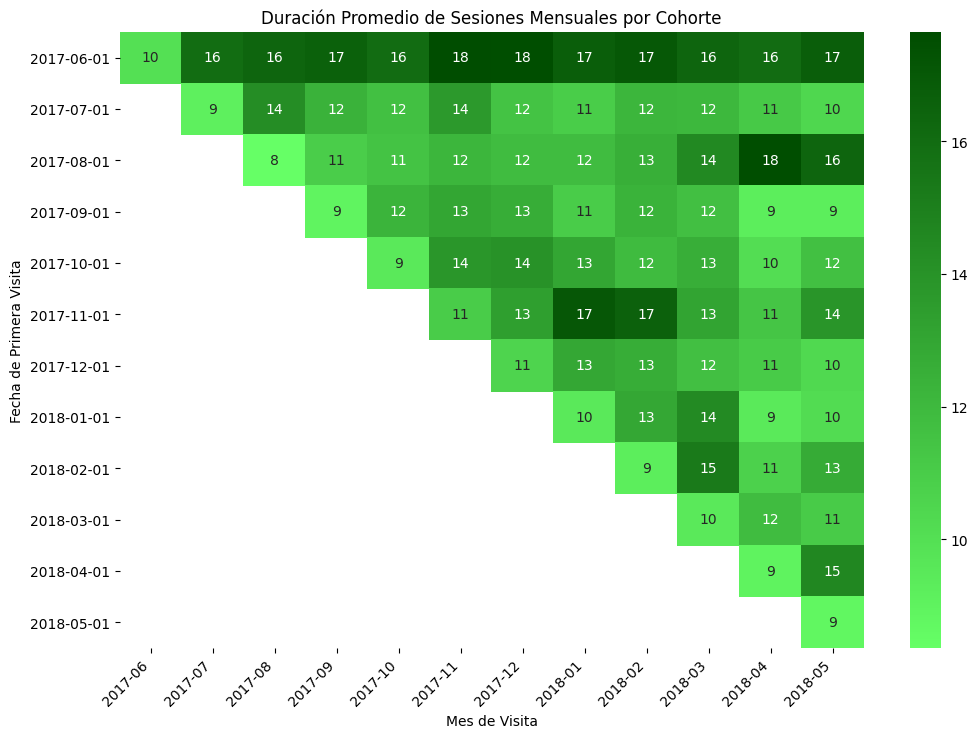

In [28]:
# Crear una paleta de colores personalizada que va de verde fuerte a verde claro
cmap = mcolors.LinearSegmentedColormap.from_list(
    'green_gradient', ['#66ff66','#004d00']  # Verde oscuro a verde claro
)

# Crear la figura y los ejes
plt.figure(figsize=(12, 8))

# Crear el heatmap con los datos redondeados
sns.heatmap(heatmap_duration, cmap=cmap, annot=True, fmt=".0f")

# Ajustar las etiquetas del eje x
plt.xticks(rotation=45, ha='right')  # Rotar las etiquetas para una mejor visualización

# Agregar título y etiquetas
plt.title("Duración Promedio de Sesiones Mensuales por Cohorte")
plt.xlabel("Mes de Visita")
plt.ylabel("Fecha de Primera Visita")

# Mostrar la gráfica
plt.show()

**Tendencias Generales:**

- La duración promedio de las sesiones varía a lo largo del tiempo, con algunos meses mostrando duraciones más altas que otros.
- Se observa un aumento general en la duración de las sesiones a lo largo del tiempo, particularmente en algunos meses a partir de 2017 hasta 2018.

**Meses con Alta Duración:**

- Diciembre 2017 y Abril 2018 muestran duraciones promedio más altas, con valores de hasta 18 minutos en diciembre de 2017 y 15 minutos en abril de 2018.
- Estos picos podrían indicar eventos especiales, promociones, o cambios en la plataforma que llevaron a una mayor interacción durante esos meses.

**Meses con Baja Duración:**

- Agosto 2017 tiene una duración promedio baja, con un promedio de 8 minutos.
- Febrero 2018 también muestra duraciones bajas, especialmente en el comienzo del mes.

**Cambios a lo Largo del Tiempo:**

- La duración promedio parece ser variable en función de la fecha de la primera visita. Por ejemplo, la duración promedio para visitas iniciadas en mayo 2018 es consistentemente baja, lo que podría ser un patrón estacional o relacionado con eventos específicos.

**Impacto de la Primera Visita:**

- Las visitas realizadas en meses posteriores (a partir de octubre 2017) tienden a mostrar una mayor duración promedio en comparación con los meses anteriores. Esto podría reflejar la maduración de los usuarios con el tiempo, una mayor familiaridad con la plataforma, o mejoras en el contenido ofrecido.


#### Stickiness (Frecuencia con la que los usuarios regresan a la plataforma.)

**Calcular DAU promedio (Usuarios Activos Diarios)**

In [29]:
# Asegúrate de que 'Start Ts' sea de tipo datetime
visits['Start Ts'] = pd.to_datetime(visits['Start Ts'])

# Ahora puedes extraer la fecha usando .dt.date
visits['Start Ts'] = visits['Start Ts'].dt.date

# Calcula el DAU (Daily Active Users)
dau = visits.groupby('Start Ts')['Uid'].nunique()

# Calcula el promedio diario de usuarios activos
average_dau = dau.mean()

# Imprime el resultado
average_dau

907.9917582417582

**Calcular MAU (Usuarios Activos Mensuales)**

In [30]:
mau = visits.groupby('visit_month')['Uid'].nunique()
mau = mau.reset_index()
mau

,visit_month,Uid
0,2017-06-01,13259
1,2017-07-01,14183
2,2017-08-01,11631
3,2017-09-01,18975
4,2017-10-01,29692
5,2017-11-01,32797
6,2017-12-01,31557
7,2018-01-01,28716
8,2018-02-01,28749
9,2018-03-01,27473


**Calcular el Stickiness**

In [31]:
mau['stickiness'] = (average_dau/mau['Uid'])*100
mau['visit_month'] = mau['visit_month'].dt.date
mau

,visit_month,Uid,stickiness
0,2017-06-01,13259,6.848116
1,2017-07-01,14183,6.401972
2,2017-08-01,11631,7.806653
3,2017-09-01,18975,4.785200
4,2017-10-01,29692,3.058035
5,2017-11-01,32797,2.768521
6,2017-12-01,31557,2.877307
7,2018-01-01,28716,3.161972
8,2018-02-01,28749,3.158342
9,2018-03-01,27473,3.305033


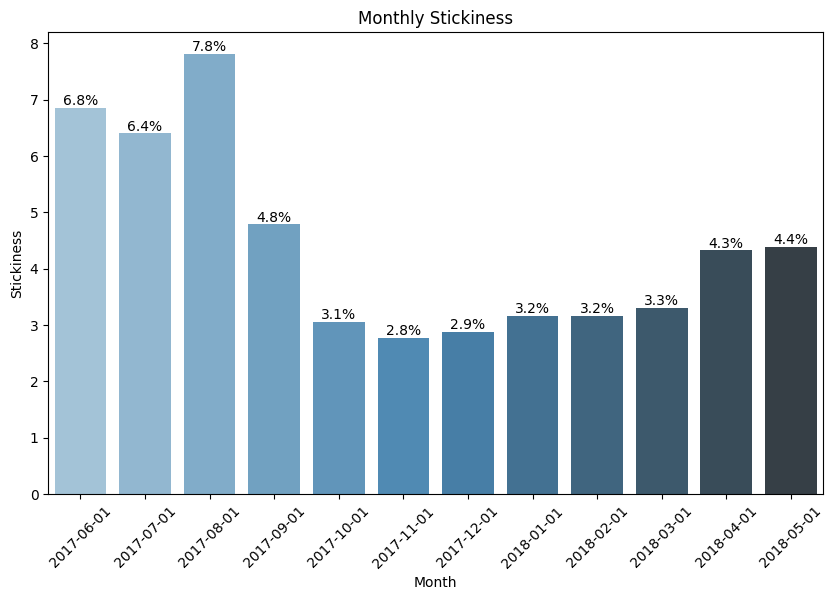

In [32]:
# Configuración del tamaño de la figura
plt.figure(figsize=(10, 6))

# Gráfico de barras con seaborn
ax = sns.barplot(x='visit_month', y='stickiness', data=mau, palette='Blues_d')

# Añadir etiquetas con el porcentaje en la parte superior de cada barra
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.1f}%',  # Formato para mostrar como porcentaje
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom')

# Etiquetas y título
plt.xlabel('Month')
plt.ylabel('Stickiness')
plt.title('Monthly Stickiness')
plt.xticks(rotation=45)
plt.show()

**Disminución de la "Stickiness" con el Crecimiento del MAU**

A medida que el número de usuarios únicos mensuales (MAU) aumenta, la "stickiness" o la frecuencia de uso diario tiende a disminuir. Por ejemplo, en octubre de 2017, cuando el MAU es más alto (29,692 usuarios), la "stickiness" es una de las más bajas (3.06%). Esto sugiere que, aunque la plataforma está atrayendo más usuarios, estos no están utilizando la plataforma con la misma frecuencia diaria, lo cual podría indicar un problema de retención o de engagement.

**Alta "Stickiness" en Meses con Menor MAU**

En meses donde el MAU es menor, como agosto de 2017, la "stickiness" es significativamente más alta (7.81%). Esto indica que aunque había menos usuarios únicos en ese mes, los que estaban activos utilizaban la plataforma de manera más consistente a diario. Esto sugiere que en periodos con menor crecimiento de usuarios, los que están presentes son más leales o comprometidos.


### Ventas

**Procesar los datos**

In [33]:
orders = orders.join(first_visit_date, on='Uid')
orders['first_visit_month'] = orders['first_visit_date'].astype('datetime64[M]')
orders['first_visit_date'] = pd.to_datetime(orders['first_visit_date'])
orders['Buy Ts'] = pd.to_datetime(orders['Buy Ts'])
orders['time_conv'] = (orders['Buy Ts'] - orders['first_visit_date']).dt.days
orders['buy_month'] = orders['Buy Ts'].astype('datetime64[M]')
orders = orders[orders['buy_month'] != '2018-06-01']
orders

,Buy Ts,Revenue,Uid,first_visit_date,first_visit_month,time_conv,buy_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:09:00,2017-06-01,0,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:14:00,2017-06-01,0,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:25:00,2017-06-01,0,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:14:00,2017-06-01,0,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:31:00,2017-06-01,0,2017-06-01
...,...,...,...,...,...,...,...
50409,2018-05-31 23:43:00,3.67,1805512004303848280,2017-12-07 23:20:00,2017-12-01,175,2018-05-01
50410,2018-05-31 23:50:00,4.64,12296626599487328624,2018-05-31 09:11:00,2018-05-01,0,2018-05-01
50411,2018-05-31 23:50:00,5.80,11369640365507475976,2018-05-31 23:05:00,2018-05-01,0,2018-05-01
50412,2018-05-31 23:54:00,0.30,1786462140797698849,2018-05-31 23:52:00,2018-05-01,0,2018-05-01


#### Promedio de Días Hasta la Covenrsión

In [34]:
heat_conv = orders.pivot_table(
    index=orders['first_visit_month'].dt.strftime('%Y-%m-%d'),  # Usar la primera visita como índice
    columns=orders['buy_month'].dt.strftime('%Y-%m'),       # Usar el mes de visita como columnas
    values='time_conv',                                              # Contar usuarios únicos (Uid)
    aggfunc='mean'                                            # Función de agregación: número de visitas
)
heat_conv = heat_conv.round(2)
heat_conv

buy_month,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05
first_visit_month,,,,,,,,,,,,
2017-06-01,1.21,31.9,68.00,97.58,127.57,161.07,189.17,221.04,251.83,279.31,310.84,343.56
2017-07-01,NaN,1.1,28.06,60.96,88.95,124.66,154.08,185.59,215.53,242.42,274.39,309.10
2017-08-01,NaN,NaN,1.03,23.87,58.07,89.66,117.73,149.68,178.51,209.23,239.27,271.87
2017-09-01,NaN,NaN,NaN,1.14,22.94,60.57,89.93,121.64,150.91,179.94,209.18,244.85
2017-10-01,NaN,NaN,NaN,NaN,1.13,27.16,58.35,92.63,119.17,149.92,183.34,215.24
2017-11-01,NaN,NaN,NaN,NaN,NaN,1.24,22.43,57.40,85.09,115.50,148.81,179.34
2017-12-01,NaN,NaN,NaN,NaN,NaN,NaN,1.24,26.98,57.59,88.41,119.55,151.30
2018-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.05,22.00,54.82,87.45,117.74
2018-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.09,24.20,59.60,92.09


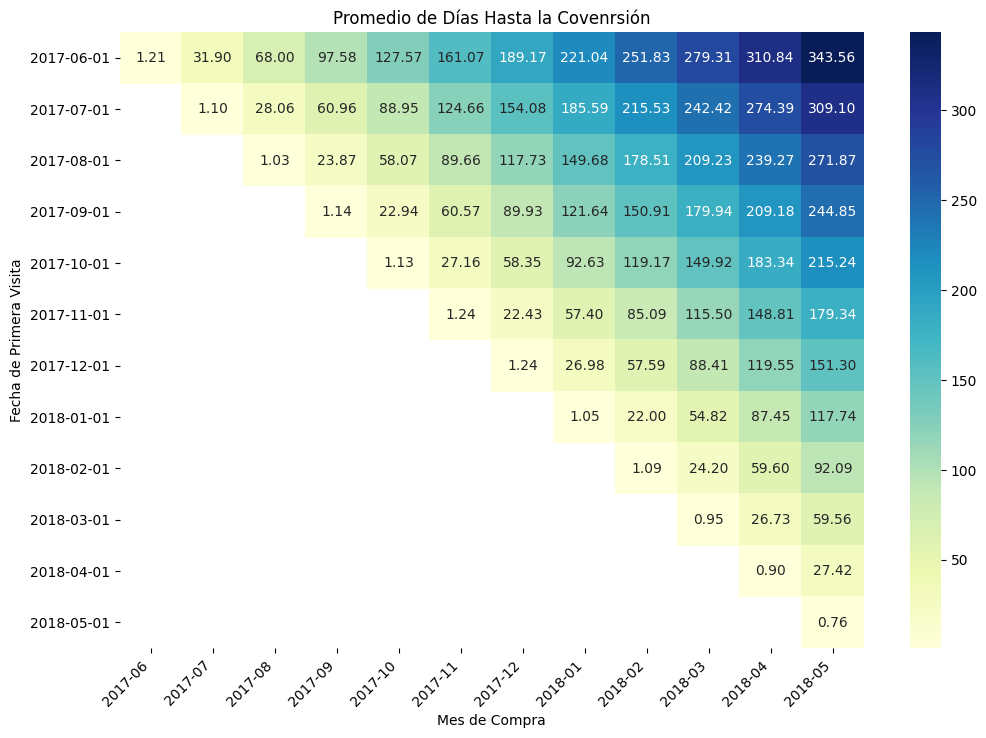

In [35]:
# Crear la figura y los ejes
plt.figure(figsize=(12, 8))

# Crear el heatmap
sns.heatmap(heat_conv, cmap="YlGnBu", annot=True, fmt=".2f")  # Redondear a dos decimales

# Ajustar las etiquetas del eje x
plt.xticks(rotation=45, ha='right')  # Rotar las etiquetas para una mejor visualización

# Agregar título y etiquetas
plt.title("Promedio de Días Hasta la Covenrsión")
plt.xlabel("Mes de Compra")
plt.ylabel("Fecha de Primera Visita")

# Mostrar la gráfica
plt.show()

**Tendencias Generales:**

Los tiempos promedio de conversión tienden a ser más altos en meses anteriores a los meses de compra. Esto podría indicar que los usuarios que visitan por primera vez en un mes específico a menudo tardan más tiempo en realizar una compra en comparación con los usuarios que visitan en meses más recientes.

Por ejemplo, para los usuarios que visitaron por primera vez en junio de 2017, el tiempo promedio hasta la compra es bajo (**1.21 días**) si compran en el mismo mes, pero aumenta significativamente en los meses siguientes.


#### Cuántos pedidos hacen durante un período de tiempo dado

In [36]:
heat_order_count = orders.pivot_table(
    index=orders['first_visit_month'].dt.strftime('%Y-%m-%d'),  # Usar la primera visita como índice
    columns=orders['buy_month'].dt.strftime('%Y-%m'),       # Usar el mes de visita como columnas
    values='Buy Ts',                                              # Contar usuarios únicos (Uid)
    aggfunc='count'                                            # Función de agregación: número de visitas
)
heat_order_count

buy_month,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05
first_visit_month,,,,,,,,,,,,
2017-06-01,2354.0,387.0,273.0,442.0,516.0,428.0,500.0,329.0,371.0,318.0,185.0,294.0
2017-07-01,NaN,1976.0,184.0,204.0,196.0,192.0,170.0,142.0,156.0,151.0,87.0,87.0
2017-08-01,NaN,NaN,1350.0,221.0,205.0,179.0,162.0,107.0,102.0,145.0,83.0,84.0
2017-09-01,NaN,NaN,NaN,2520.0,492.0,329.0,275.0,135.0,192.0,194.0,97.0,112.0
2017-10-01,NaN,NaN,NaN,NaN,4270.0,619.0,356.0,235.0,245.0,219.0,131.0,158.0
2017-11-01,NaN,NaN,NaN,NaN,NaN,3912.0,766.0,369.0,317.0,304.0,140.0,175.0
2017-12-01,NaN,NaN,NaN,NaN,NaN,NaN,3989.0,464.0,262.0,250.0,113.0,158.0
2018-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2940.0,452.0,255.0,94.0,123.0
2018-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3184.0,413.0,130.0,139.0


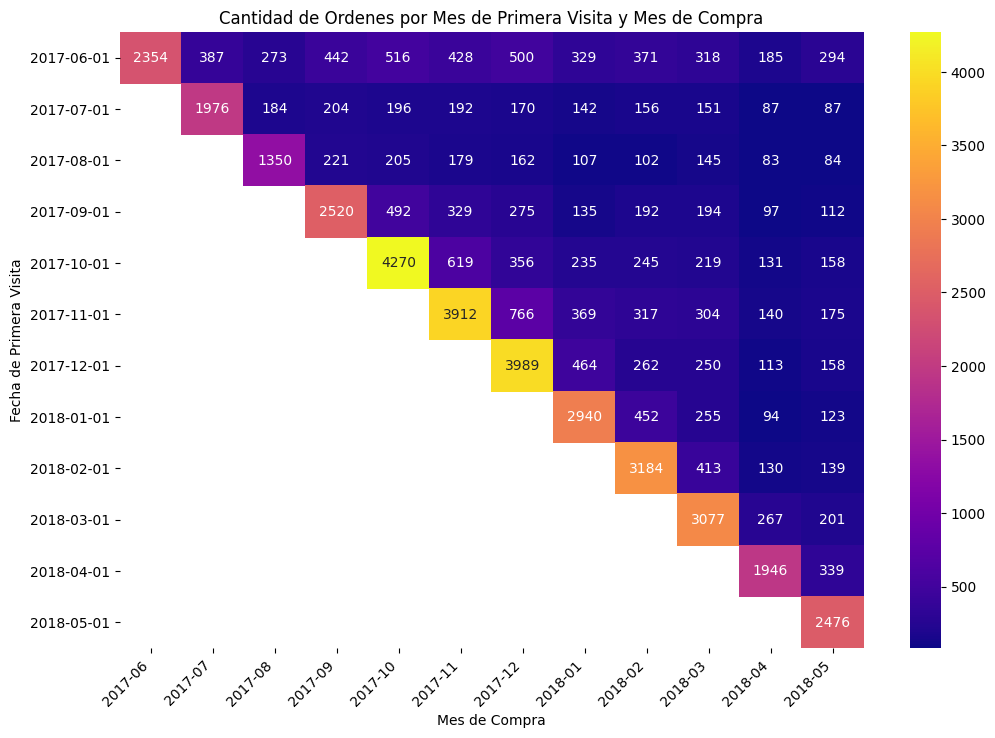

In [37]:
# Crear la figura y los ejes
plt.figure(figsize=(12, 8))

# Crear el heatmap
sns.heatmap(heat_order_count, cmap="plasma", annot=True, fmt=".0f")

# Ajustar las etiquetas del eje x
plt.xticks(rotation=45, ha='right')  # Rotar las etiquetas para una mejor visualización

# Agregar título y etiquetas
plt.title("Cantidad de Ordenes por Mes de Primera Visita y Mes de Compra")
plt.xlabel("Mes de Compra")
plt.ylabel("Fecha de Primera Visita")

# Mostrar la gráfica
plt.show()

**Distribución de Compras por Meses:**

- **Altos Volúmenes de Compra en Meses Recientes:** Los meses más recientes tienden a mostrar mayores volúmenes de compra en comparación con los meses anteriores. Por ejemplo, en octubre de 2017 y en enero de 2018, hay números significativamente altos de compras, indicando un aumento en la actividad de compra en estos períodos.

- **Picos en Fechas Específicas:** Hay picos notables en ciertos meses, como octubre de 2017 con 4270 compras y febrero de 2018 con 3184 compras. Estos picos podrían correlacionarse con promociones, eventos especiales o campañas de marketing.


#### Cuál es el tamaño promedio de compra

In [38]:
order_revenue_mean = orders.pivot_table(
    index=orders['first_visit_month'].dt.strftime('%Y-%m-%d'),  # Usar la fecha de la primera visita como índice
    columns=orders['buy_month'].dt.strftime('%Y-%m'),            # Usar el mes de compra como columnas
    values='Revenue',                                            # Tomar los ingresos para calcular el promedio
    aggfunc='mean'                                              # Función de agregación: calcular el promedio
)

# Mostrar la tabla dinámica
order_revenue_mean

buy_month,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05
first_visit_month,,,,,,,,,,,,
2017-06-01,4.060106,6.885220,5.365165,8.783010,7.636802,6.599252,6.979900,6.902158,6.247736,10.948553,11.913568,6.557177
2017-07-01,NaN,4.997414,5.756957,5.435784,5.015102,4.411406,4.694588,4.140845,4.937820,4.798146,6.793448,5.369655
2017-08-01,NaN,NaN,4.618378,4.512760,4.884634,5.286089,5.000247,4.980374,4.771079,8.594689,10.007710,4.472857
2017-09-01,NaN,NaN,NaN,4.903651,7.521301,6.415289,37.959747,9.544296,9.948177,4.983711,5.065773,3.737232
2017-10-01,NaN,NaN,NaN,NaN,4.300309,6.154814,3.727584,4.502340,4.259061,4.667534,4.419160,4.151266
2017-11-01,NaN,NaN,NaN,NaN,NaN,4.225918,3.482481,3.639160,4.320284,3.647171,5.054500,3.992000
2017-12-01,NaN,NaN,NaN,NaN,NaN,NaN,4.225871,3.747910,16.024046,20.495279,12.898849,11.279304
2018-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.604425,4.317920,4.567686,3.254043,4.288374
2018-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.615776,4.804988,5.101461,6.482086


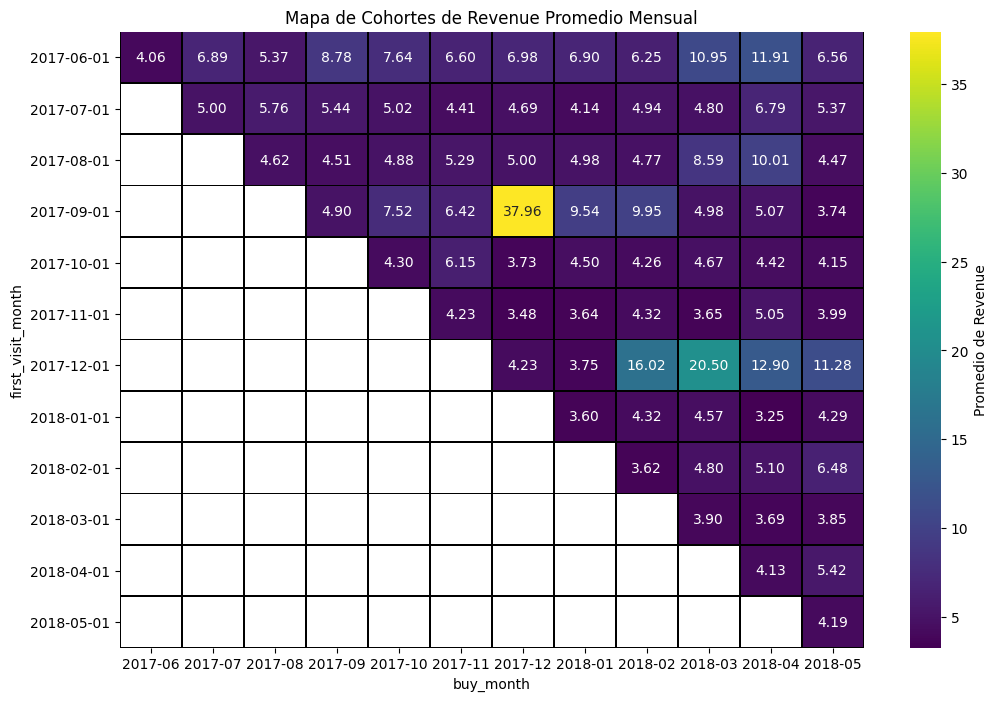

In [39]:
plt.figure(figsize=(12, 8))  # Ajusta el tamaño de la figura según sea necesario
ax = sns.heatmap(
    order_revenue_mean,
    cmap='viridis',             # Colormap de colores (puedes cambiarlo si lo deseas)
    annot=True,                # Añadir etiquetas en las celdas
    fmt=".2f",                 # Formato de las etiquetas en las celdas (hasta dos decimales)
    linewidths=0.5,            # Ancho de las líneas que separan las celdas
    linecolor='black',         # Color de las líneas que separan las celdas
    cbar_kws={'label': 'Promedio de Revenue'}  # Etiqueta de la barra de color
)

# Configurar el título del gráfico
plt.title('Mapa de Cohortes de Revenue Promedio Mensual')

# Mostrar el gráfico
plt.show()

**Patrones de Retención de Clientes:**

- **Clientes de Junio 2017 (2017-06-01):**
  - Comienzan con un ingreso promedio de **4.06** en junio de 2017.
  - Incrementan sus ingresos hasta alcanzar un pico de aproximadamente **11.91** en abril de 2018.
  - Indica que estos clientes continúan comprando y aumentando su gasto con el tiempo.

- **Clientes de Septiembre 2017 (2017-09-01):**
  - Muestran un ingreso promedio muy alto en diciembre de 2017 (**37.96**), lo que podría indicar una campaña específica, una promoción o un comportamiento atípico.
  - Posteriormente, los ingresos disminuyen, lo que sugiere una menor retención o gasto continuo.

**Tendencias Generales de Ingresos:**

- **Incremento Inicial y Luego Estabilización:**
  - La mayoría de las cohortes muestran un aumento inicial en los ingresos durante los primeros meses posteriores a la primera visita, seguido de una estabilización o leve disminución.

- **Variabilidad entre Cohortes:**
  - Algunas cohortes, como la de diciembre 2017 (**2017-12-01**), muestran picos significativos en meses específicos posteriores a la primera visita, lo que podría estar relacionado con campañas de marketing específicas o eventos estacionales.

**Identificación de Cohortes con Alto Potencial:**

- **Cohortes con Crecimiento Sostenido:**
  - Por ejemplo, la cohorte de junio 2017 muestra un crecimiento sostenido en ingresos durante varios meses, lo que indica clientes leales y de alto valor.

- **Cohortes con Ingresos Fluctuantes:**
  - Cohortes como la de septiembre 2017 muestran fluctuaciones significativas, lo que sugiere la necesidad de investigar factores que afectan su comportamiento de compra.


#### ¿Cuánto dinero traen? (LTV)

In [40]:
orders['Buy Ts'] = pd.to_datetime(orders['Buy Ts'])
costs['dt'] = pd.to_datetime(costs['dt'])

orders['order_month'] = orders['Buy Ts'].astype('datetime64[M]')
costs['month'] = costs['dt'].astype('datetime64[M]')

first_orders = orders.groupby('Uid').agg({'order_month': 'min'}).reset_index()
first_orders.columns = ['Uid', 'first_order_month']

cohort_sizes = (
    first_orders.groupby('first_order_month')
    .agg({'Uid': 'nunique'})
    .reset_index()
)
cohort_sizes.columns = ['first_order_month', 'n_buyers']

margin_rate = 0.4

orders_ = pd.merge(orders, first_orders, on='Uid')
cohorts = (
    orders_.groupby(['first_order_month', 'order_month'])
    .agg({'Revenue': 'sum'})
    .reset_index()
)
report = pd.merge(cohort_sizes, cohorts, on='first_order_month')

report['gp'] = report['Revenue'] * margin_rate
report['age'] = (
    report['order_month'] - report['first_order_month']
) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')

report['ltv'] = report['gp'] / report['n_buyers']

result = report.pivot_table(
    index='first_order_month', columns='age', values='ltv', aggfunc='mean'
).round()

result = result.fillna('')

monthly_costs = costs.groupby('month').sum()
report_ = pd.merge(
    report, monthly_costs, left_on='first_order_month', right_on='month'
)
report_['cac'] = report_['costs'] / report_['n_buyers']

report_['romi'] = report_['ltv'] / report_['cac']
result = report_.pivot_table(
    index='first_order_month', columns='age', values='romi', aggfunc='mean'
)

result = report_.pivot_table(
    index='first_order_month',
    columns='age',
    values='ltv',
    aggfunc='mean'
)

result = result.round(2)

result


age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,1.89,0.19,0.18,0.38,0.41,0.29,0.38,0.23,0.22,0.24,0.23,0.1
2017-07-01,2.40,0.13,0.25,0.14,0.07,0.06,0.05,0.06,0.06,0.06,0.06,NaN
2017-08-01,2.11,0.19,0.18,0.16,0.20,0.11,0.08,0.16,0.12,0.08,NaN,NaN
2017-09-01,2.26,0.45,0.21,1.59,0.16,0.26,0.28,0.10,0.07,NaN,NaN,NaN
2017-10-01,2.00,0.21,0.08,0.06,0.06,0.05,0.03,0.05,NaN,NaN,NaN,NaN
2017-11-01,2.06,0.16,0.08,0.13,0.06,0.02,0.05,NaN,NaN,NaN,NaN,NaN
2017-12-01,1.90,0.10,0.37,0.43,0.13,0.14,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,1.65,0.12,0.12,0.06,0.03,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,1.66,0.11,0.03,0.03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


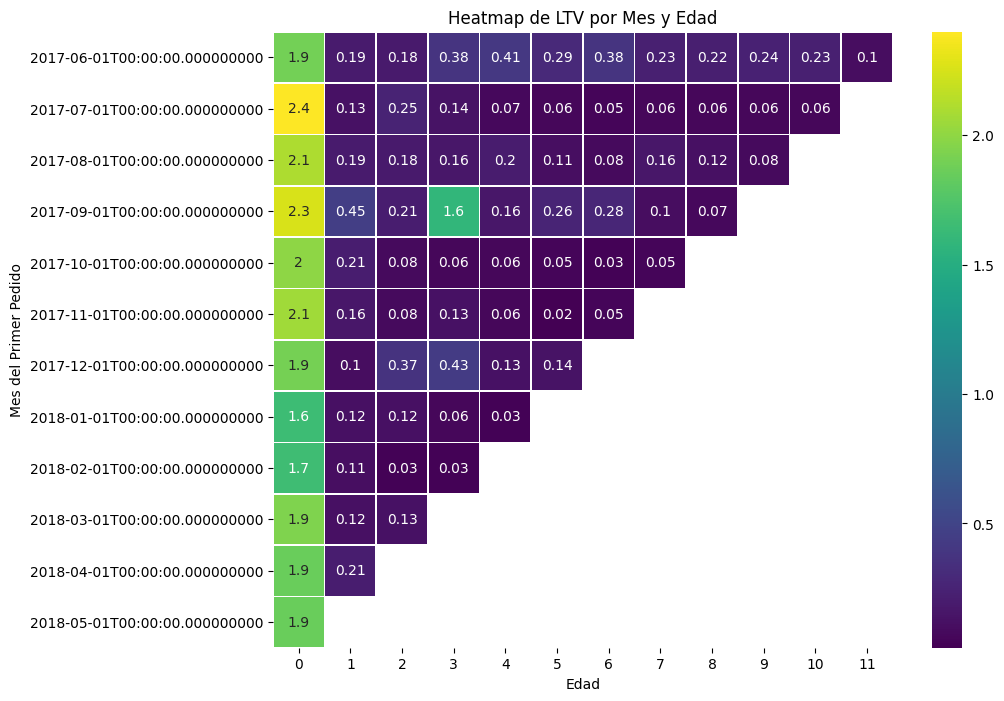

In [41]:
# Configuración del tamaño del gráfico
plt.figure(figsize=(10, 8))

# Crear el heatmap
sns.heatmap(result, annot=True, cmap='viridis', linewidths=0.5)

# Añadir título y etiquetas
plt.title('Heatmap de LTV por Mes y Edad')
plt.xlabel('Edad')
plt.ylabel('Mes del Primer Pedido')

# Mostrar el gráfico
plt.show()

In [42]:
m11_cum_ltv = result.cumsum(axis=1).mean(axis=0)[11]  

print('El LTV promedio durante 12 meses desde el primer pedido:', m11_cum_ltv)

El LTV promedio durante 12 meses desde el primer pedido: 4.74


**Tendencias mensuales:**

- El **LTV** comienza alto en el primer mes desde el primer pedido en la mayoría de los casos, con valores disminuyendo a medida que avanza el tiempo (edad del pedido).
- Por ejemplo, en **junio de 2017**, el LTV inicia en **1.89** y luego disminuye gradualmente con el paso del tiempo.
- Algunos meses muestran fluctuaciones, como en **septiembre de 2017**, donde el LTV sube de forma pronunciada a **1.59** en la edad 3.

**LTV promedio durante 11 meses:**

- El cálculo del **LTV acumulado promedio** hasta el mes 12 (edad 11) muestra que el valor promedio acumulado es de **4.74**.
- Esto indica que, en promedio, un cliente genera un valor acumulado de **4.74** durante los primeros 12 meses desde su primer pedido.



### Marketing

#### Cuánto dinero se gastó Total/por fuente de adquisición/a lo largo del tiempo

**Total de dinero gastado**

In [43]:
# Asegurar de que la columna 'dt' esté en formato datetime
costs['dt'] = pd.to_datetime(costs['dt'])

# Imprime el total de dinero gastado y el rango de fechas
print(f"El total de dinero gastado es {costs['costs'].sum():.2f} desde el {costs['dt'].min().date()} hasta el {costs['dt'].max().date()}.")

El total de dinero gastado es 329131.59 desde el 2017-06-01 hasta el 2018-05-31.


**Dinero gastado por fuente de adquisición**

In [44]:
# Agrupar por fuente de adquisición (Uid) y por mes de compra (buy_month) o pedido (order_month)
monthly_spend_per_source = costs.groupby(['source_id', 'month'])['costs'].sum().reset_index()

# Renombrar la columna para mayor claridad
monthly_spend_per_source.columns = ['source_id', 'month', 'Total_cost']

monthly_spend_per_source = monthly_spend_per_source.pivot_table(
    index='source_id',  # O el nombre correcto de la columna que representa la fuente de adquisición
    columns='month',  # La columna que representa los meses
    values='Total_cost',  # La columna con los valores que quieres sumar
    aggfunc='sum',  # Función de agregación
    fill_value=0  # Opcional, para rellenar los valores faltantes con 0
)
monthly_spend_per_source = np.ceil(monthly_spend_per_source).astype(int)

monthly_spend_per_source

month,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01
source_id,,,,,,,,,,,,
1,1126,1073,952,1503,2316,2446,2342,2187,2205,1894,1328,1468
2,2428,2334,1812,2986,4845,5248,4898,4158,4475,3944,2994,2690
3,7732,7675,6144,9964,15738,17026,16220,14809,14229,13081,9297,9412
4,3515,3530,3218,5193,6421,5389,7681,5833,5712,5962,4409,4215
5,2617,2999,2186,3850,5768,6326,5873,5372,5072,4530,3502,3670
9,286,303,249,416,610,684,658,548,552,481,374,363
10,315,330,233,461,628,793,646,615,481,527,389,410


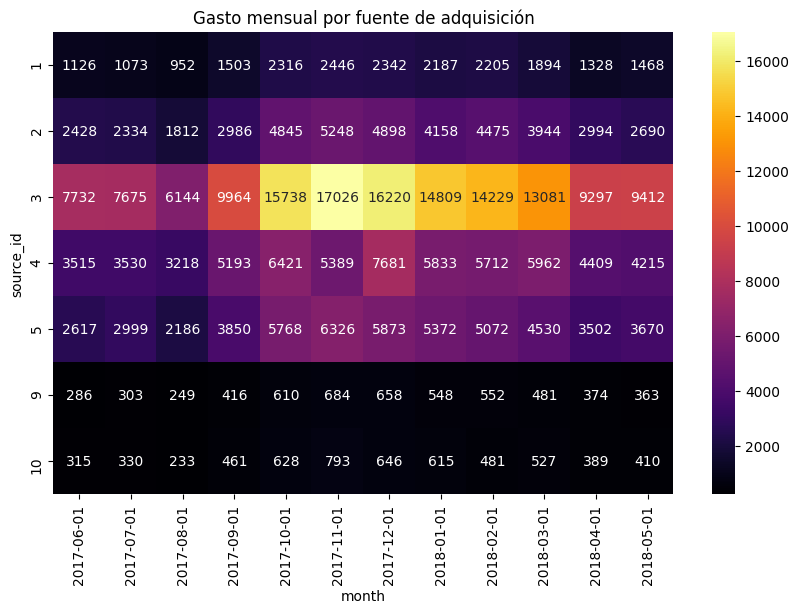

In [45]:
monthly_spend_per_source.columns = monthly_spend_per_source.columns.strftime('%Y-%m-%d')


# Configurar el tamaño de la figura
plt.figure(figsize=(10, 6))

# Crear el mapa de calor sin anotaciones en las celdas
sns.heatmap(monthly_spend_per_source, cmap='inferno', annot=True, fmt='d')

# Título del gráfico
plt.title('Gasto mensual por fuente de adquisición')

# Mostrar el gráfico
plt.show()

**Comparaciones entre Fuentes**

- **Fuente 3** es la que más dinero gasta en comparación con otras fuentes, especialmente en los meses de octubre y noviembre de 2017.
- **Fuente 9** y **Fuente 10** tienen el gasto más bajo, con valores significativamente menores que las otras fuentes.
- Las fuentes con mayores gastos suelen mostrar picos en los meses de octubre y noviembre de 2017.

**Patrones Estacionales**

- Es posible observar un patrón estacional, con un aumento en el gasto durante los meses de octubre y noviembre de 2017 en muchas fuentes. Esto podría estar relacionado con eventos específicos, promociones o cambios estacionales en el mercado.


#### Costo de adquisición de clientes de cada una de las fuentes.

In [46]:
new_customers = orders.groupby('Uid')['Buy Ts'].min().reset_index()
new_customers['Uid'].nunique()

36522

In [47]:
costs

,source_id,dt,costs,month
0,1,2017-06-01,75.199997,2017-06-01
1,1,2017-06-02,62.250000,2017-06-01
2,1,2017-06-03,36.529999,2017-06-01
3,1,2017-06-04,55.000000,2017-06-01
4,1,2017-06-05,57.080002,2017-06-01
...,...,...,...,...
2537,10,2018-05-27,9.920000,2018-05-01
2538,10,2018-05-28,21.260000,2018-05-01
2539,10,2018-05-29,11.320000,2018-05-01
2540,10,2018-05-30,33.150002,2018-05-01


In [48]:
cost_by_source = costs.groupby('source_id')['costs'].sum().reset_index()
cost_by_source.columns = ['source_id', 'costs']

# Redondear los costos a dos decimales
cost_by_source['costs'] = cost_by_source['costs'].round(2)

# Calcular CAC y redondear a dos decimales
cost_by_source['cac'] = (cost_by_source['costs'] / new_customers['Uid'].nunique()).round(2)

# Calcular el ROMI antes de formatear las columnas
cost_by_source['romi'] = (cost_by_source['cac'] / m11_cum_ltv).round(2)

# Ahora redondear y formatear los valores para la visualización
cost_by_source['costs'] = cost_by_source['costs'].map('{:.2f}'.format)
cost_by_source['cac'] = cost_by_source['cac'].map('{:.2f}'.format)
cost_by_source['romi'] = cost_by_source['romi'].map('{:.2f}'.format)
cost_by_source = cost_by_source.sort_values('source_id')

# Imprimir el resultado
cost_by_source

,source_id,costs,cac,romi
0,1,20833.27,0.57,0.12
1,2,42806.04,1.17,0.25
2,3,141321.62,3.87,0.82
3,4,61073.60,1.67,0.35
4,5,51757.10,1.42,0.30
5,9,5517.49,0.15,0.03
6,10,5822.49,0.16,0.03


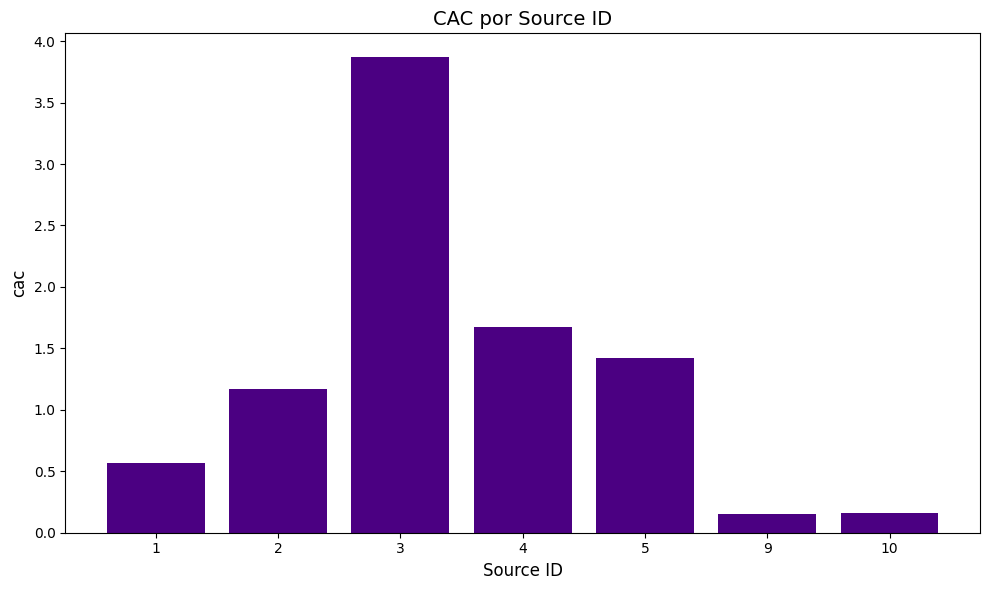

In [49]:


# Extraer los datos
source_ids = cost_by_source['source_id'].astype(str)  # Convertimos los source_id a cadenas para evitar el espacio entre ellos
romi_values = cost_by_source['cac'].astype(float)    # Aseguramos que los valores de romi sean numéricos

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))  # Ajustar el tamaño del gráfico
plt.bar(source_ids, romi_values, color='indigo')

# Añadir etiquetas y título
plt.title('CAC por Source ID', fontsize=14)
plt.xlabel('Source ID', fontsize=12)
plt.ylabel('cac', fontsize=12)


# Mostrar el gráfico
plt.tight_layout()
plt.show()


El Costo de Adquisición de Clientes según la métrica **CAC** se distribuye de la siguiente manera:

- **Fuente 9** y **Fuente 10** son las más económicas con un CAC de **0.15** y **0.16**, respectivamente, lo que las hace las fuentes más eficientes en términos de costos.
- **Fuente 1** tiene un CAC de **0.57**, manteniéndose en un rango bajo comparado con otras fuentes.
- **Fuente 2** genera un CAC intermedio de **1.17**, siendo más costosa que la **Fuente 1**, pero aún moderada.
- **Fuente 5** tiene un CAC de **1.42**, más elevado, aunque todavía dentro de un rango competitivo.
- **Fuente 4** presenta un CAC de **1.67**, que refleja un costo de adquisición considerable.
- **Fuente 3** tiene el CAC más alto, con un valor de **3.87**, lo que indica que adquirir un cliente a través de esta fuente es significativamente más costoso que en las demás.


En conclusión, Fuentes 9 y 10 destacan por sus bajos costos de adquisición, mientras que Fuente 3 es la más costosa en términos de CAC.

#### Cuán rentables eran las inversiones

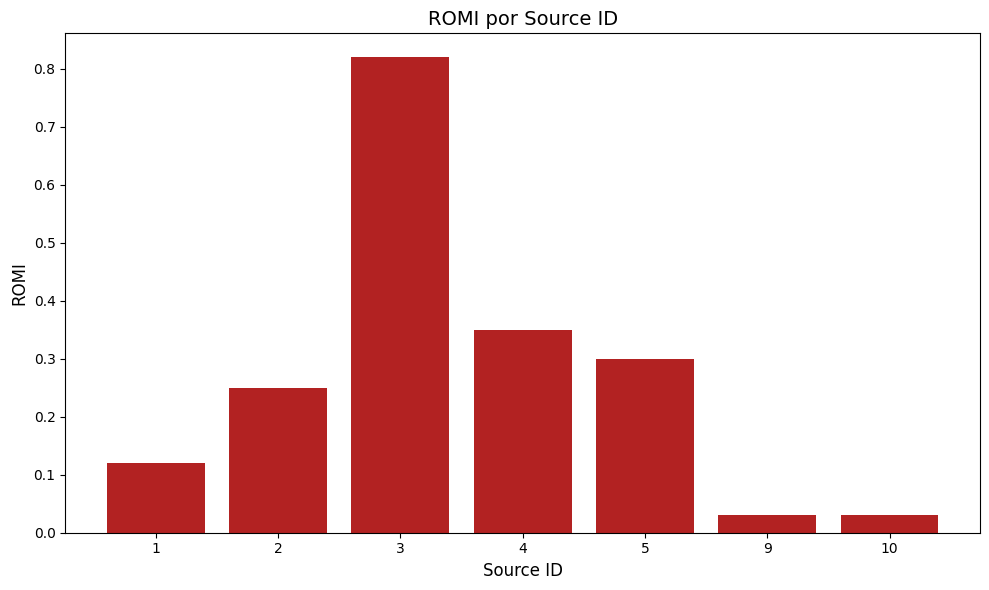

In [50]:


# Extraer los datos
source_ids = cost_by_source['source_id'].astype(str)  # Convertimos los source_id a cadenas para evitar el espacio entre ellos
romi_values = cost_by_source['romi'].astype(float)    # Aseguramos que los valores de romi sean numéricos

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))  # Ajustar el tamaño del gráfico
plt.bar(source_ids, romi_values, color='firebrick')

# Añadir etiquetas y título
plt.title('ROMI por Source ID', fontsize=14)
plt.xlabel('Source ID', fontsize=12)
plt.ylabel('ROMI', fontsize=12)


# Mostrar el gráfico
plt.tight_layout()
plt.show()


La rentabilidad de las inversiones según la métrica **ROMI**, se observa que:

- **Fuente 3** es la más rentable con un **ROMI de 0.82** (82% de retorno), aunque tiene el costo más alto.
- **Fuente 4** ofrece un retorno del **35%** y es moderadamente rentable.
- **Fuente 5** tiene un retorno del **30%**, con un **CAC más bajo** que la Fuente 4.
- **Fuente 2** genera un **25% de retorno**, pero tiene un **CAC más alto**.
- **Fuente 1** tiene un retorno bajo del **12%**.
- **Fuentes 9 y 10** son las menos rentables con un **retorno del 3%**.

En conclusión, las fuentes **3 y 4** son las más rentables, mientras que las fuentes **9 y 10** no parecen ser inversiones efectivas. Se recomienda priorizar las fuentes más rentables y revisar las menos productivas.


## Punto clave a destacar

**Visitas y Sesiones**

**Visitas Diarias:**
- **Promedio Diario**: 908 usuarios.
- **Variabilidad**: Moderada, con valores entre 594 y 1,173 usuarios para la mayoría de los días.
- **Picos**: Hasta 3,319 usuarios en algunos días.

**Visitas Semanales:**
- **Promedio Semanal**: 5,716 usuarios.
- **Variabilidad**: Alta, con semanas desde 2,021 hasta 10,586 usuarios.
- **Tendencias**: Las visitas tienden a ser más altas en las primeras semanas y disminuyen gradualmente.

**Sesiones Diarias:**
- **Promedio Diario**: 987 sesiones.
- **Variabilidad**: Alta, con algunos días alcanzando hasta 4,042 sesiones.
- **Tendencias**: La duración promedio de las sesiones ha aumentado con el tiempo, siendo más alta en meses recientes.

**Sesiones Múltiples por Día:**
- **Promedio Diario**: 62 sesiones múltiples.
- **Variabilidad**: Consistente, con picos de actividad que pueden estar asociados a eventos específicos.

**Duración de las Sesiones:**
- **Tendencias**: General aumento en la duración promedio desde 2017 a 2018.
- **Meses Destacados**: Diciembre 2017 y abril 2018 tienen duraciones más altas.

**Stickiness:**
- **Tendencias**: Disminuye con el aumento del MAU, con una alta "stickiness" en meses con menor MAU.

**Análisis de Ventas**

**Promedio de Días Hasta la Conversión:**
- **Tendencias Generales**: Los tiempos de conversión suelen ser más cortos cerca de la primera visita. Ejemplo: Junio 2017 con un promedio de 1.21 días.

**Volumen de Compras por Mes:**
- **Tendencias**: Aumento en los meses más recientes, con picos notables en octubre de 2017 y febrero de 2018.

**Tamaño Promedio de Compra:**
- **Patrones**: Aumento del gasto con el tiempo, aunque algunas cohortes como la de septiembre de 2017 presentan fluctuaciones significativas.

**Valor del Tiempo de Vida del Cliente (LTV):**
- **Tendencias Mensuales**: LTV tiende a disminuir con el tiempo. El promedio acumulado hasta el mes 12 es 4.74.

**Cohortes con Alto Potencial:**
- **Cohortes Sostenidas**: Ejemplo, junio de 2017 muestra un crecimiento continuo.
- **Cohortes Fluctuantes**: Ejemplo, septiembre de 2017 presenta ingresos fluctuantes.

**Marketing**

**Gasto Total:**
- **Total Gastado**: $329,131.59
- **Fuentes Destacadas**: Fuente 3 con el mayor gasto, mientras que las Fuentes 9 y 10 tienen el gasto más bajo.

**Costo de Adquisición de Clientes (CAC):**
- **Fuentes de Bajo Costo**: Fuente 9 (0.15) y Fuente 10 (0.16).
- **Fuentes de Alto Costo**: Fuente 3 (3.87), siendo la más costosa.

**Rentabilidad de las Inversiones (ROMI):**
- **Fuentes Más Rentables**: Fuente 3 (82% de retorno) y Fuente 4 (35% retorno).
- **Fuentes Menos Rentables**: Fuente 9 (3% retorno) y Fuente 10 (3% retorno).

# Recomendaciones de Fuentes/Plataformas

## Fuentes/Plataformas Recomendadas:

1. **Fuente 3**
2. **Fuente 4**

## Fundamentación de la Selección:

### 1. Métricas Enfocadas:

- **Rentabilidad de las Inversiones (ROMI):**
  - **Fuente 3:** ROMI de 0.82 (82% de retorno). A pesar del alto CAC, su alto retorno hace que sea la fuente más rentable.
  - **Fuente 4:** ROMI de 0.35 (35% de retorno). Moderadamente rentable con un retorno considerable.

- **Costo de Adquisición de Clientes (CAC):**
  - **Fuente 3:** CAC de 3.87, lo que es alto, pero su rentabilidad compensa el costo.
  - **Fuente 4:** CAC de 1.67, que es relativamente alto pero aún aceptable considerando el ROMI.

### 2. Justificación de la Selección:

- **Fuente 3:** A pesar de tener el CAC más alto, su alto ROMI la convierte en una opción valiosa. El alto retorno en comparación con el costo significa que, aunque el costo por adquisición es alto, el retorno sobre la inversión es significativamente positivo, lo que justifica su recomendación.

- **Fuente 4:** Ofrece un buen equilibrio entre costo y retorno. Aunque el CAC es relativamente alto, su ROMI es moderadamente bueno, lo que indica una inversión rentable con un retorno más alto que muchas otras fuentes.

## Conclusiones Basadas en los Valores Métricos:

1. **Fuente 3 y Fuente 4** se destacan por su rentabilidad, a pesar de sus costos de adquisición relativamente altos. Las métricas de ROMI demuestran que estas fuentes ofrecen un buen retorno sobre la inversión.

2. **Fuentes 9 y 10** presentan los costos de adquisición más bajos pero también los retornos más bajos, lo que indica que, aunque son económicas en términos de CAC, no proporcionan un retorno significativo en relación con la inversión realizada. Estas fuentes no se recomiendan debido a su bajo ROMI.

3. **Fuentes 1, 2, 5** tienen un equilibrio variable entre CAC y ROMI, y no se destacan como altamente recomendables en comparación con Fuente 3 y Fuente 4.

## Recomendación General:

- Priorizar **Fuente 3** y **Fuente 4** debido a su alta rentabilidad. Evaluar y ajustar estrategias para las fuentes menos rentables y reconsiderar la inversión en fuentes con bajo ROMI como **Fuente 9** y **Fuente 10**. 

Estas recomendaciones se basan en un análisis detallado de la rentabilidad (ROMI) y el costo de adquisición de clientes (CAC), lo que proporciona una visión clara de dónde se obtienen los mejores retornos por inversión.


<div style="background-color: #6a0dad; color: #ffffff; padding: 10px; border-radius: 5px;">
    <p>Este proyecto ha sido un desafío personal. Me costó mucho trabajo y más tiempo del que inicialmente había previsto. Agradezco de antemano que te tomes el tiempo de leer este proyecto y estoy abierto a cualquier feedback que se pueda ofrecer. Te deseo un excelente día.</p>
</div>
